# Micorhaplotypes candidate panel selection

The aim of this notebook is to analyse the per-window summary statistics generated in the first notebooke and assemble a candidate panel. The selection process is a hard mathematical optimisation problem and here we provide two complementary and effective way to perform the task. The codebase is also modular and can be extended to use different optmisation algorithms.

The notebook consist of four parts:
1. [Environment and data](Environment-and-data)
1. [Data exploration](Data-exploration)
1. [Candidate selection](Candidate-selection)
    1. ["Greedy" candidate selection]("Greedy"-candidate-selection)
    1. [Evenly-spaced candidate selection](Evenly-spaced-candidate-selection)

All the data required to run this notebook and generated in the previous one are also provided pre-calcualted in this repository.

## Environment and data

This notebook can be run from any computer and can also work from a compute node within Google Cloud, for example via MyBinder or Google Colab which are free interactive computing service running in the cloud. Here we only use common packages that come preinstalled in many computing environment, without strong version dependencies.

In [33]:
# Load all required packages and print their version
from importlib.metadata import version

print(f'Numpy version: {version("numpy")}')
print(f'Pandas version: {version("pandas")}')
print(f'Matplotlib version: {version("matplotlib")}')
print(f'scikit-allel version: {version("scikit-allel")}')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import allel

# Setup plotting backend
%matplotlib inline

Numpy version: 1.23.5
Pandas version: 2.1.3
Matplotlib version: 3.8.2
scikit-allel version: 1.3.7


### Loading the data

First, we need to load the per-window summary statistics and prepare the dataframe for analysis.

In [9]:
windows_df = pd.read_csv("../precomputed/genome_stats.csv", index_col=0)
windows_df = windows_df.sort_values('chrom')
# Add a supplementary column containing the window midpoint, useful for plotting
windows_df = windows_df.assign(midpoint=windows_df.loc[:, ["window_start", "window_end"]].mean(axis=1))
windows_df.head()

,chrom,window_start,window_end,variant_counts,unique_allele_counts,unique_alleles_with_missing_index,unique_alleles_with_het_index,unique_allele_frequencies,unique_allele_count,entropy,het,midpoint
0,PvP01_01_v1,121493,121692,1,[387 3 225],[],[1],"[0.6292682926829268, 0.004878048780487805, 0.3...",3,0.685315,0.470149,121592.5
381,PvP01_01_v1,634843,635042,4,[ 1 30 46 1 2 1 6 202 3 252 23 ...,"[0, 5, 6, 12]","[4, 8, 11]","[0.0016260162601626016, 0.04878048780487805, 0...",17,1.605061,0.711957,634942.5
382,PvP01_01_v1,634893,635092,3,[ 1 6 235 3 252 23 1 1 4 31 51 7],"[0, 1, 7]","[3, 6]","[0.0016260162601626016, 0.00975609756097561, 0...",12,1.399306,0.674974,634992.5
383,PvP01_01_v1,634943,635142,2,[ 1 7 239 3 283 1 51 30],"[0, 1]","[3, 5]","[0.0016260162601626016, 0.011382113821138212, ...",8,1.176073,0.627811,635042.5
384,PvP01_01_v1,634993,635192,1,[ 8 291 3 313],[0],[2],"[0.013008130081300813, 0.47317073170731705, 0....",4,0.780273,0.516893,635092.5


As all of the analysis are limited to the core genome, we also need to load the genome regions annotation.

In [8]:
pv_regions = pd.read_csv("../supplementary_files/Pv4_regions.bed",
                         sep="\t", comment="t",
                         names=["chrom", "chromStart", "chromEnd", "name"])
pv_regions[["chromStart", "chromEnd"]] += 1
pv_regions["length"] = pv_regions["chromEnd"] - pv_regions["chromStart"]
pv_core = pv_regions[pv_regions["name"]=="Core"]
pv_core.head()

,chrom,chromStart,chromEnd,name,length
1,PvP01_01_v1,116542,677963,Core,561421
3,PvP01_01_v1,679790,903592,Core,223802
6,PvP01_02_v1,100156,162349,Core,62193
8,PvP01_02_v1,164088,745644,Core,581556
11,PvP01_03_v1,108062,630664,Core,522602


## Data exploration

Basic data exploration

In [11]:
man_colours = ['#C62828','#D81B60','#8E24AA','#5E35B1','#3949AB','#1E88E5','#039BE5','#00ACC1','#00897B','#43A047','#7CB342','#C0CA33','#FFB300','#F4511E']

In [10]:
def plot_man(df, field, maxy):

    rcParams = plt.rcParams
    rcParams['font.size'] = 14
    rcParams['axes.labelsize'] = 14

    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=12

    fig, ax = plt.subplots(figsize=(16, 7))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylim([0,maxy])
    ax.set_xlabel('Chromosome')
    ax.set_ylabel(f'{field} per microhaplotypetype')

    colour_i=0
    chrom_num = 0
    for chrom in df.chrom.unique():
        chrom_num += 1
        chrom_df = df.loc[df['chrom']==chrom]
        windows = chrom_df.shape[0]
        increment = 1/windows
        delta = 0
        x = chrom_num - (windows*increment/2)
        for index, row in chrom_df.iterrows():
            ax.scatter(x, row[field], c=man_colours[colour_i],s=row[field])
            x+=increment
        colour_i+=1
    plt.xticks(np.arange(1, 15, 1.0), rotation = 45)

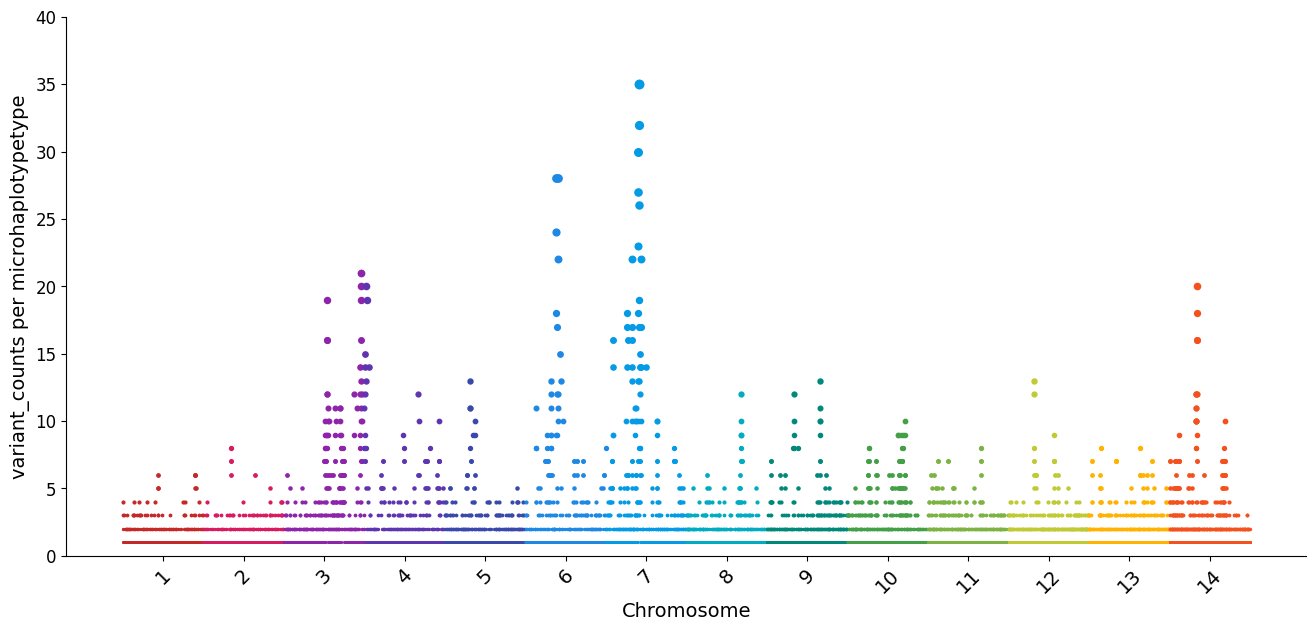

In [13]:
# Plot N Snps per microhaplotypes
plot_man(windows_df, 'variant_counts',40)

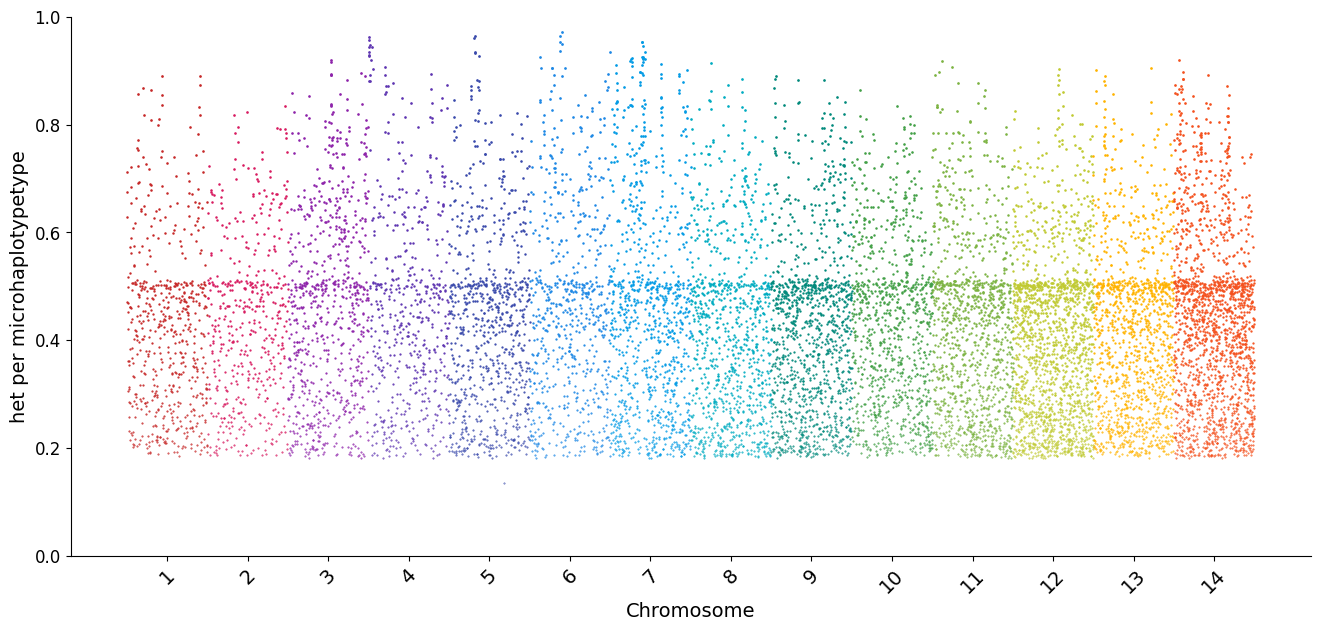

In [15]:
plot_man(windows_df, 'het',1)

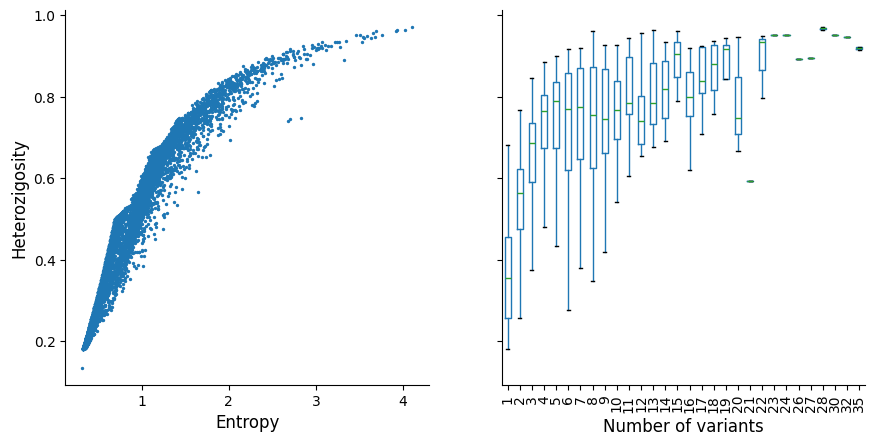

In [20]:
def plot_het_v_entropy(df):

    rcParams = plt.rcParams
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 12

    plt.rcParams['xtick.labelsize']=10
    plt.rcParams['ytick.labelsize']=10

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.scatter(df['entropy'], df['het'], s=2)
    ax1.set_xlabel('Entropy')
    ax1.set_ylabel('Heterozigosity')

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    boxplot = df.boxplot(column='het', by='variant_counts',
                         rot=90, grid=False, showfliers=False,
                         ax=ax2)
    
    ax2.set_xlabel('Number of variants')
    ax2.set_ylabel('')
    ax2.title.set_text('')
    fig.suptitle('')

plot_het_v_entropy(windows_df)

Some comments
Entropy and Het are correlated, so we decided to only use one of the two for this example.
Het stabilises so no need to include very high density windows which also explode the number of haplotypes

## Candidate selection
Panel selection can be seen as a complex and multidimensional optimisation problem: evenly spaces or not too close, maximise diversity. Several ways to approach it, here two examples.

### Utility functions

To guarantee that all core regions are represented, we want microhaplotypes to be distributed proportionally to the size of each region. The utility function below does that and returns the number of expected microhaplotypes per core region, also accounting for rounding errors.

In [21]:
def get_n_muhap_per_core(df, n_muhap_total):
    core_length = sum(df["length"])
    # First try with a naive distribution proportional to the region size
    n_muhap_per_core = np.round((df["length"]/core_length)*n_muhap_total).astype('int')

    # Check whether the number obtained is what is required (i.e. if there are rounding effects)
    delta = n_muhap_total - sum(n_muhap_per_core)

    # Supplement the smallest (or deplete the largest) regions if an andjustment is required
    if delta > 0: # Less markers than expected, add to the smallest
        smallest = n_muhap_per_core.nsmallest(delta).index
        n_muhap_per_core[smallest] += 1
    elif delta < 0: # More markers than expected, remove from the largest
        largest = n_muhap_per_core.nlargest(-delta).index
        n_muhap_per_core[largest] -= 1
    
    return n_muhap_per_core

Visual representation of markers postion along the genome

In [22]:
regions_pal = {"Cen": "white", "Core":"white", "In":"orange" , "Sub":"red"}

In [23]:
def plot_markers(markers, regions):

    rcParams = plt.rcParams
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 10

    #plt.rcParams['xtick.labelsize']=10
    #plt.rcParams['ytick.labelsize']=10
    
    fig, ax = plt.subplots(nrows=14, sharex = True, sharey = True, figsize=(10, 10))

    ax[0].set_xlim([0,regions["chromEnd"].max()])
    ax[0].set_ylim([0,1])
    ax[0].get_xaxis().get_major_formatter().set_scientific(False)
    ax[0].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    for chr_num in range(0,15):
        chr_name = f'PvP01_{chr_num:02}_v1'
    
        chr_regions = regions[regions["chrom"] == chr_name]
        chr_markers = markers[markers["chrom"] == chr_name]

        ax[chr_num-1].spines['right'].set_visible(False)
        ax[chr_num-1].spines['top'].set_visible(False)
        ax[chr_num-1].spines['left'].set_visible(False)

        for _, r in chr_regions.iterrows():
            p = mpl.patches.Rectangle((r["chromStart"], -1), r["length"], 2, edgecolor='None', facecolor=regions_pal[r["name"]])
            ax[chr_num-1].add_patch(p)

        ax[chr_num-1].vlines(chr_markers["window_start"],-1,1, color="black") 
        ax[chr_num-1].set_ylabel(chr_name, rotation='horizontal', ha='right')
        ax[chr_num-1].set_yticks([])

### Greedy

[Greedy optimisation](https://en.wikipedia.org/wiki/Greedy_algorithm)

In [24]:
def get_greedy_muhap_list(df, core, n_muhap_per_core, min_distance=1_000):
    
    muhap_list = []
    
    for (_, row), n_core in zip(core.iterrows(), n_muhap_per_core):
        core_windows = df[ (df["chrom"] == row["chrom"]) &
                           (df["window_start"] >= row["chromStart"]) &
                           (df["window_end"] <= row["chromEnd"]) ].copy()
        
        local_list = []
        
        while len(local_list) < n_core:
            core_windows.sort_values("het", ascending=False, inplace=True)
            if not np.isnan(core_windows.iloc[0]["midpoint"]):
                local_list += [core_windows.index[0].tolist()]
                midpoint = core_windows.iloc[0]["midpoint"]
                core_windows.mask( abs(core_windows["midpoint"] - midpoint) < min_distance, inplace=True)
            else:
                print(f'Only {len(local_list)} out of {n_core} windows found in \
{row["chrom"]}:{row["chromStart"]}-{row["chromEnd"]} - try decreasing min_distance')
                break
   
        muhap_list += local_list
    
    return muhap_list


In [25]:
windows_subset = windows_df[windows_df["variant_counts"].between(3,10)]

In [26]:
n_muhap_total = 150
n_muhap_per_core = get_n_muhap_per_core(pv_core, n_muhap_total)
greedy_muhap_list = get_greedy_muhap_list(windows_subset, pv_core, n_muhap_per_core, 50_000)

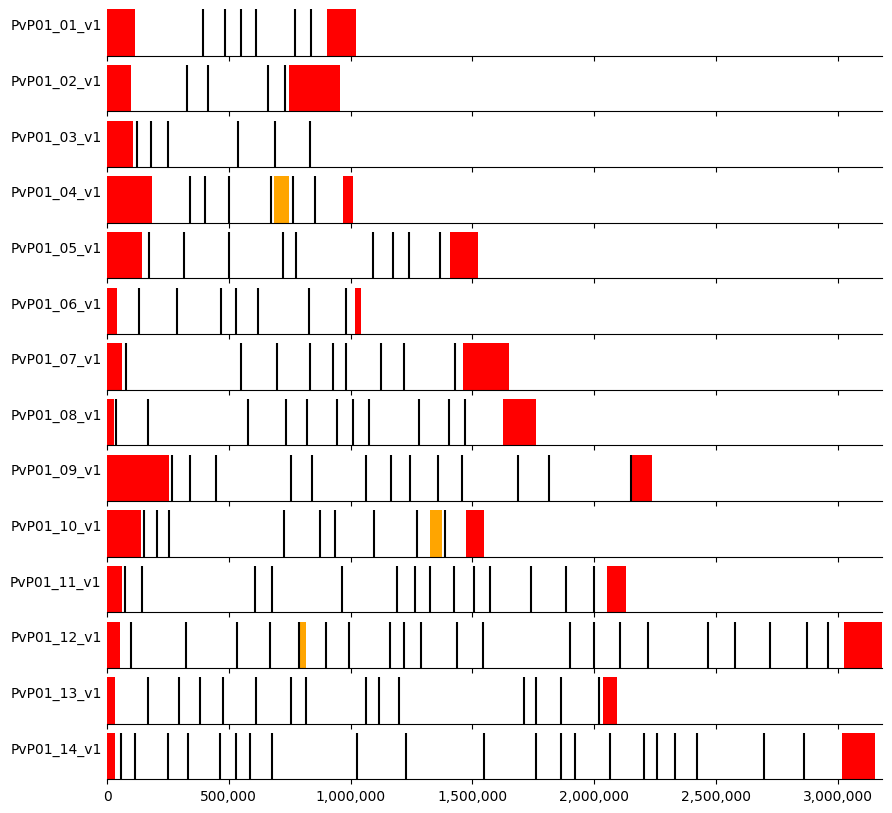

In [27]:
plot_markers(windows_subset.loc[greedy_muhap_list], pv_regions.sort_values(["chrom","chromStart"]))

### Evenly spaced

In [28]:
def get_max_idx(df):
    return df.idxmax()

def get_even_muhap_list(df, core, n_muhap_per_core, spacing=1_000, verbose=False):

    muhap_list = []

    for (_, row), n_core in zip(core.iterrows(), n_muhap_per_core):
        core_windows = df[ (df["chrom"] == row["chrom"]) &
                           (df["window_start"] >= row["chromStart"]) &
                           (df["window_end"] <= row["chromEnd"]) ].copy()

        core_windows.sort_values("window_start", inplace=True)
        
        local_list = []

        if n_core > 0:
            win_size = np.max([0, np.ceil(row["length"]/n_core).astype("int") - spacing])
            local_list, a, NN = allel.windowed_statistic(core_windows["midpoint"].astype("int"), core_windows["het"], get_max_idx,
                                                         size=win_size, step=win_size+spacing,
                                                         start=row["chromStart"], stop=row["chromEnd"])
            if np.isnan(local_list).any():
                print(f'Only {np.count_nonzero(NN)} out of {n_core} windows found in \
{row["chrom"]}:{row["chromStart"]}-{row["chromEnd"]}')
                if verbose:
                    print(f'L:{row["length"]}, W:{win_size}, N:{n_core}')
                    print(a)
                    print(NN)
                local_list = local_list[~np.isnan(local_list)].astype("int")

        muhap_list = [*muhap_list, *local_list]
    
    return muhap_list

In [31]:
windows_subset = windows_df[windows_df["variant_counts"].between(3,10)]

In [34]:
n_muhap_total = 174
n_muhap_per_core = get_n_muhap_per_core(pv_core, n_muhap_total)
even_muhap_list = get_even_muhap_list(windows_subset, pv_core, n_muhap_per_core, 5_000)
len(even_muhap_list)

Only 3 out of 5 windows found in PvP01_01_v1:116542-677963
Only 4 out of 5 windows found in PvP01_02_v1:164088-745644
Only 5 out of 6 windows found in PvP01_06_v1:337570-1017210
Only 7 out of 9 windows found in PvP01_07_v1:60454-1256419
Only 1 out of 2 windows found in PvP01_07_v1:1258300-1463495
Only 7 out of 9 windows found in PvP01_08_v1:28424-1132375
Only 8 out of 10 windows found in PvP01_09_v1:979223-2156012
Only 5 out of 7 windows found in PvP01_10_v1:140990-1011339
Only 2 out of 3 windows found in PvP01_10_v1:1013168-1327962
Only 10 out of 12 windows found in PvP01_11_v1:62172-1603557
Only 14 out of 15 windows found in PvP01_12_v1:1050262-3028219
Only 7 out of 9 windows found in PvP01_13_v1:987035-2038386
Only 12 out of 16 windows found in PvP01_14_v1:30988-2143533
Only 6 out of 7 windows found in PvP01_14_v1:2145270-3019712


150

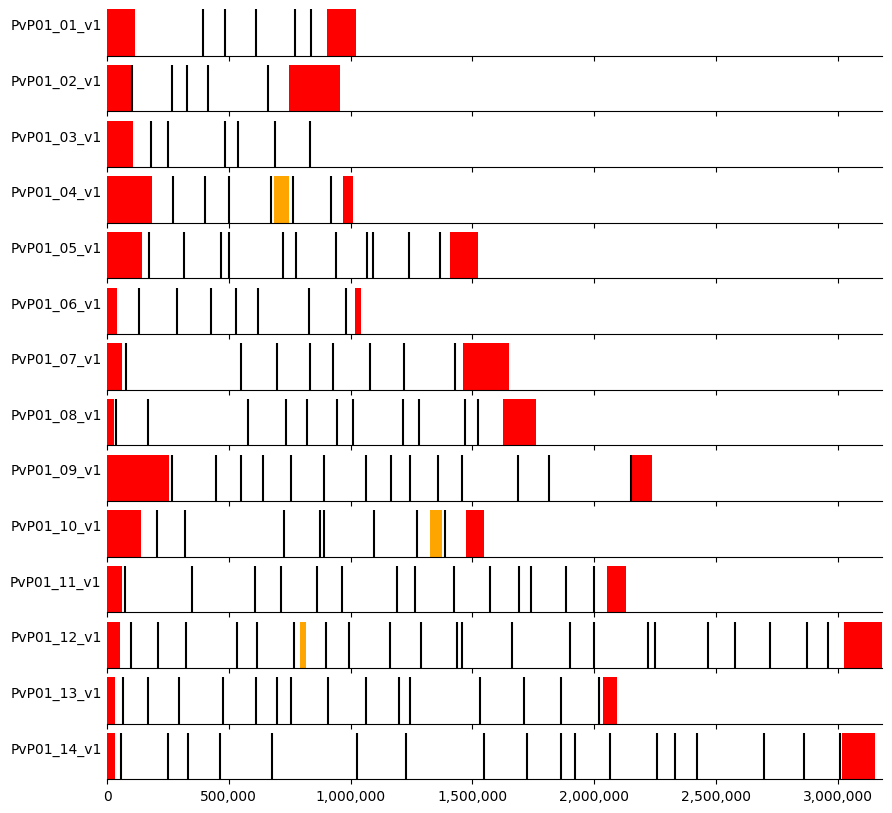

In [35]:
plot_markers(windows_subset.loc[even_muhap_list], pv_regions.sort_values(["chrom","chromStart"]))